# CURVE FITTING TESTS
This notebook is a showcase of three different approaches for finding a curve that can overlap the dotted line in the middle of the road.

For the porpuse of the tests I didn't bother with the line segmentation. My starting point is a bunch of already segmented images where the middle dotted line in highlighted in yellow.

The three procedures tested here are Implicit Function Fit, Bezier Fit and Spline interpolation.

Before tackling the various aproaches I did a bit of preprocessing consisting in:
- Line extraction
- Bird Eye View
- K means clustering
- Pca rotation and ordering

For both the pre processing steps and the three procedures I'll go more into the details in the corresponding sections

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Input and Pre processing

### Read Image

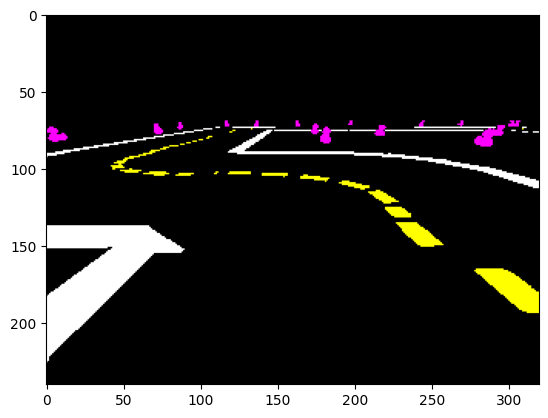

In [138]:
source = cv2.imread('source/b.png')
source = cv2.cvtColor(source, cv2.COLOR_BGR2RGB)
plt.imshow(source)

### Bird Eye View

This step is needed because it "loosens" the dotted line, making it more easily processable.
I used the polisegmentation package

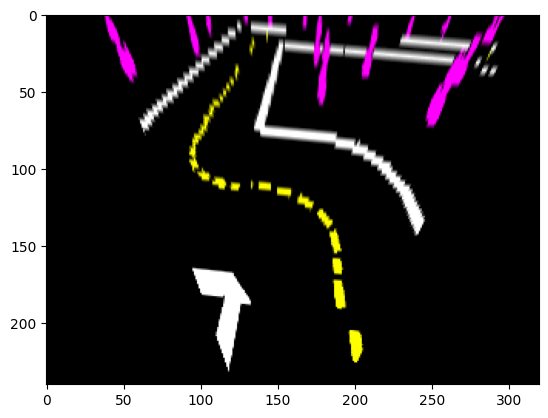

In [139]:
from poliduckie_segmentation import BirdEyeView
birdeye = BirdEyeView()
source = birdeye.computeBirdEye(source)
plt.imshow(source)
plt.show()

### Line extraction

Here I select only the dotted line and I converted to a series of x,y-points using the coordinates of the selected pixels

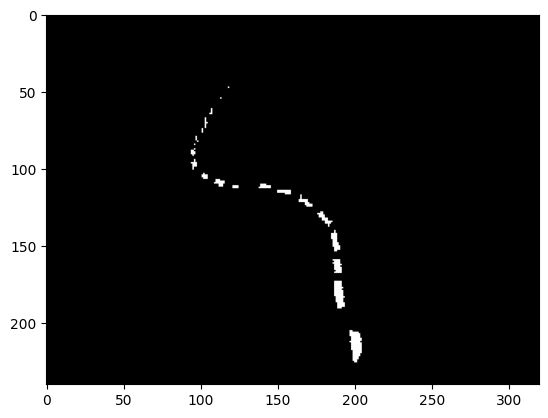

In [140]:
lineImage = cv2.inRange(source, (254, 254, 0), (256, 256, 0))
plt.imshow(lineImage, cmap='gray')

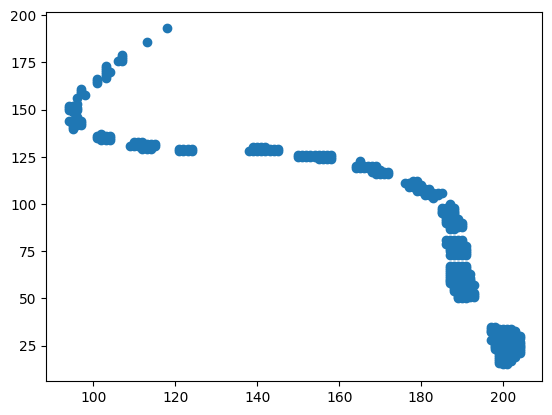

In [141]:
#find non zero points
points = np.argwhere(lineImage>0)
points = np.fliplr(points) # store them in x,y coordinates instead of row,col indices

#flip y coordinates
points[:,1] = source.shape[0] - points[:,1]

plt.scatter(points[:,0], points[:,1])
plt.show()

### K means clustering

The ideal scenario would be to have as few points as possible without sacrificing too much information, for example by slecting only one point per dot of the dotted line. To achive this I used K means clustering

In [142]:
from sklearn.cluster import KMeans

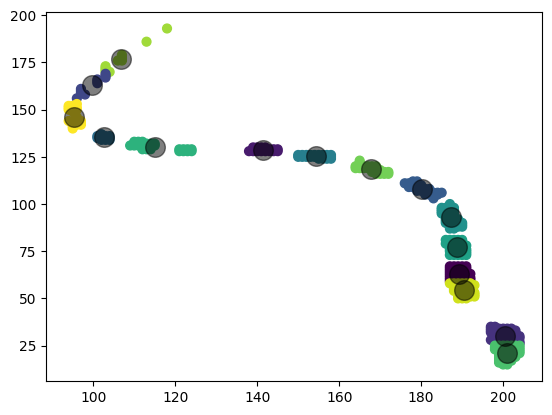

In [143]:
N_CLUSTERS = 15
MIN_ENTRIES = 8
MAX_DISTANCE = 80

kmeans = KMeans(n_clusters=N_CLUSTERS).fit(points)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

#remove centroids that are too close to each other
centroids = np.unique(centroids, axis=0)

#remove centroids with too few points
newCentroids = []
for i in range(centroids.shape[0]):
    if np.sum(labels==i) >= MIN_ENTRIES:
        newCentroids.append(centroids[i])
centroids = np.array(newCentroids)

#remove centroids that are too distant from each other
newCentroids = []
for i in range(centroids.shape[0]):
    if i == 0:
        newCentroids.append(centroids[i])
    else:
        if np.linalg.norm(centroids[i] - centroids[i-1]) < MAX_DISTANCE:
            newCentroids.append(centroids[i])
centroids = np.array(newCentroids)


plt.scatter(points[:,0], points[:,1], c=labels, s=40, cmap='viridis')
plt.scatter(centroids[:,0], centroids[:,1], c='black', s=200, alpha=0.5)
plt.show()

### PCA rotation and ordering

Some of the methods require that the points are ordered. This is not always possible but I figured that the best shot at that would be using the axis of maximum variance. To find said axis (and thus later to order the points) I used Principal Component Analysis

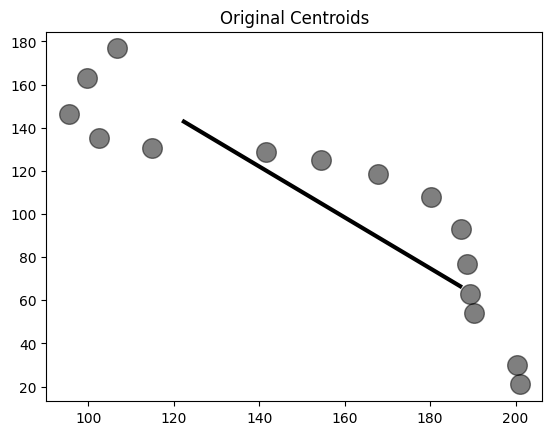

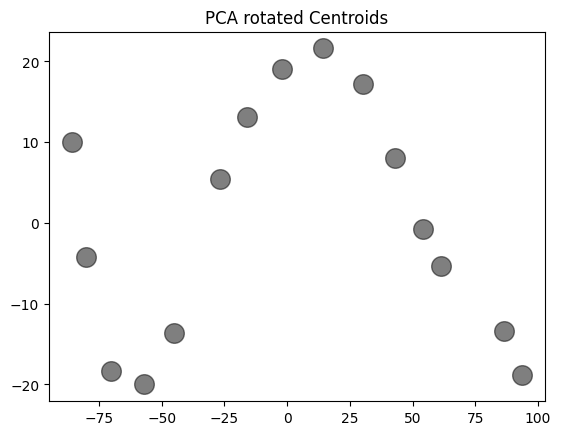

In [144]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(centroids)
pcaCentroids = pca.transform(centroids)

centroidsMean = np.mean(centroids, axis=0)

#draw a line through the centroids mean with components as direction
mean = np.mean(centroids, axis=0)
direction = pca.components_[0]
direction = direction / np.linalg.norm(direction)
start = mean - direction * 50
end = mean + direction * 50
plt.title('Original Centroids')
plt.scatter(centroids[:,0], centroids[:,1], c='black', s=200, alpha=0.5)
plt.plot([start[0], end[0]], [start[1], end[1]], c='black', linewidth=3)
plt.show()

plt.title('PCA rotated Centroids')
plt.scatter(pcaCentroids[:,0], pcaCentroids[:,1], c='black', s=200, alpha=0.5)
plt.show()


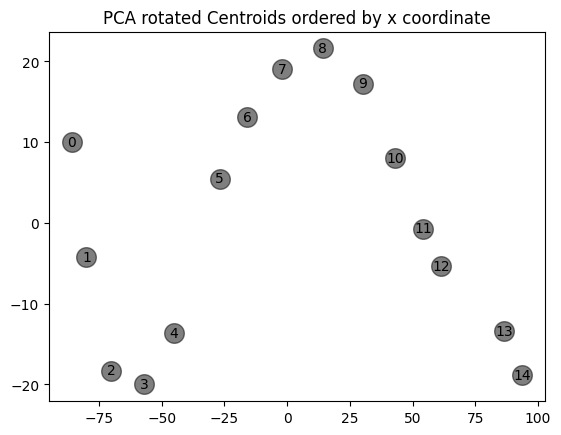

In [145]:
#sort the centroids by their x coordinate
pcaCentroids = pcaCentroids[np.argsort(pcaCentroids[:,0])]

#plot centroids with their index
plt.title('PCA rotated Centroids ordered by x coordinate')
plt.scatter(pcaCentroids[:,0], pcaCentroids[:,1], c='black', s= 200, alpha=0.5)
for i in range(pcaCentroids.shape[0]):
    plt.text(pcaCentroids[i,0], pcaCentroids[i,1], str(i), fontsize=10, horizontalalignment='center', verticalalignment='center')
plt.show()

### X, Y extraction

In [146]:
x, y = pcaCentroids[:,0], pcaCentroids[:,1]

## Implicit function fit

This method tries to fit an implicit function to the data points optimizing for minimum veriance. The main benefit is that, in this way, the order of the points does not matter. Unfortunately I didn't get any truly usable results

In [147]:
xDeg = 3
xBasis = [lambda x : np.power(x, d) for d in range(2, xDeg + 1)] + [lambda x : np.ones(x.shape), lambda x : x]
XMatrix = np.concatenate([np.array([f(x)]).T for f in xBasis], axis=1)

yDeg = 3
yBasis = [lambda y : np.power(y, d) for d in range(2, yDeg + 1)]
yMatrix = np.concatenate([np.array([f(y)]).T for f in yBasis], axis=1)

In [148]:
A = np.concatenate([XMatrix, yMatrix], axis=1)
Y = np.array([y]).T

In [149]:
A_inv = np.linalg.pinv(A)
coeffs = A_inv@Y
print(coeffs)

[[-3.99354122e-06]
 [-3.99353950e-06]
 [ 8.31994408e-02]
 [ 2.84468543e-02]
 [ 1.33490102e-03]
 [ 1.33490102e-03]]


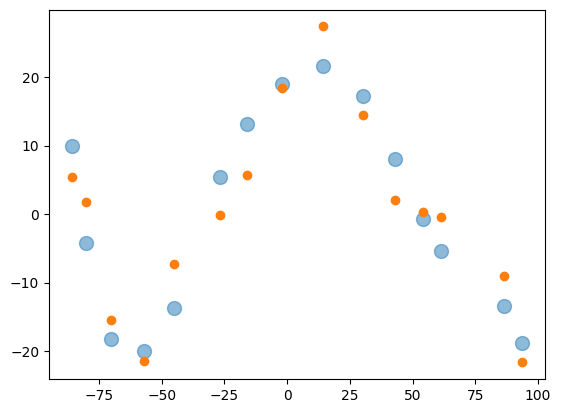

In [150]:
pred = A@coeffs
plt.scatter(x, y, label='real', s=100, alpha=0.5)
plt.scatter(x, pred, label='predictions')
#plt.legend()
plt.show()

In [151]:
def getValue(x, y):
    return sum([coeffs[i][0]*base(x) for i, base in enumerate(xBasis)]) + sum([coeffs[i + len(xBasis)][0]*base(y) for i, base in enumerate(yBasis)]) - y

getValue(np.array([0, 1]),np.array([0, 1]))

array([ 0.08319944, -0.88569189])

(477, 1858)


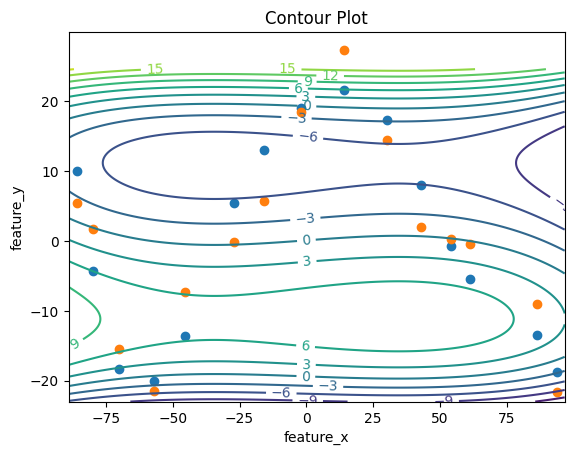

In [152]:
feature_x = np.arange(min(x) - 3, max(x) + 3, 0.1)
feature_y = np.arange(min(y) - 3, max(y) + 3, 0.1)
  
# Creating 2-D grid of features
[X, Y] = np.meshgrid(feature_x, feature_y)
  
fig, ax = plt.subplots(1, 1)
  
print((np.cos(X / 2) + np.sin(Y / 4)).shape)
Z = getValue(X, Y)
  
# plots contour lines
CS = ax.contour(X, Y, Z, levels = 10)
ax.clabel(CS, inline=True, fontsize=10)

ax.scatter(x, y)
ax.scatter(x, pred)
  
ax.set_title('Contour Plot')
ax.set_xlabel('feature_x')
ax.set_ylabel('feature_y')
  
plt.show()

## Bezier Fit

This method tries to fit an n degree bezier curve to the data points. This time the order of the points is crucial and that's the major downside of the approach. When the points are correctly ordered the results are decent and the "fiiting" nature of the procedure can compensate overclustering

In [153]:
from scipy.special import comb

def get_bezier_parameters(X, Y, degree=3):
    """ Least square qbezier fit using penrose pseudoinverse.

    Parameters:

    X: array of x data.
    Y: array of y data. Y[0] is the y point for X[0].
    degree: degree of the Bézier curve. 2 for quadratic, 3 for cubic.

    Based on https://stackoverflow.com/questions/12643079/b%C3%A9zier-curve-fitting-with-scipy
    and probably on the 1998 thesis by Tim Andrew Pastva, "Bézier Curve Fitting".
    """
    if degree < 1:
        raise ValueError('degree must be 1 or greater.')

    if len(X) != len(Y):
        raise ValueError('X and Y must be of the same length.')

    if len(X) < degree + 1:
        raise ValueError(f'There must be at least {degree + 1} points to '
                         f'determine the parameters of a degree {degree} curve. '
                         f'Got only {len(X)} points.')

    def bpoly(n, t, k):
        """ Bernstein polynomial when a = 0 and b = 1. """
        return t ** k * (1 - t) ** (n - k) * comb(n, k)
        #return comb(n, i) * ( t**(n-i) ) * (1 - t)**i

    def bmatrix(T):
        """ Bernstein matrix for Bézier curves. """
        return np.matrix([[bpoly(degree, t, k) for k in range(degree + 1)] for t in T])

    def least_square_fit(points, M):
        M_ = np.linalg.pinv(M)
        return M_ * points

    T = np.linspace(0, 1, len(X))
    M = bmatrix(T)
    points = np.array(list(zip(X, Y)))
    
    final = least_square_fit(points, M).tolist()
    final[0] = [X[0], Y[0]]
    final[len(final)-1] = [X[len(X)-1], Y[len(Y)-1]]
    return final

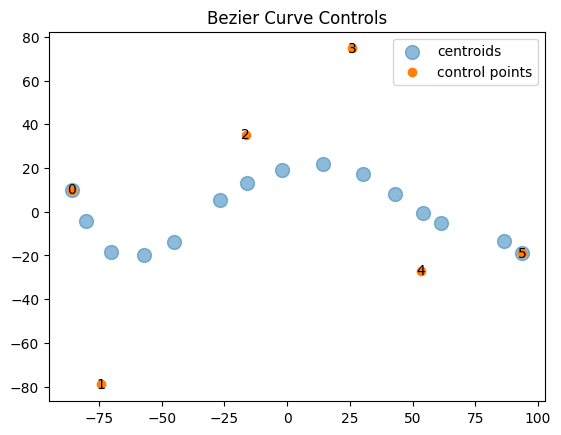

In [154]:
controls = np.array(get_bezier_parameters(x, y, degree=5))

#plot the bezier curve controls
plt.title('Bezier Curve Controls')
plt.scatter(x, y, label='centroids', s=100, alpha=0.5)

#plot controls with index drawn
plt.scatter(controls[:, 0], controls[:, 1], label=f'control points')
for i, control in enumerate(controls):
    plt.text(control[0], control[1], str(i), fontsize=10, horizontalalignment='center', verticalalignment='center')

plt.legend()
plt.show()

C:\Users\Paolo\AppData\Local\Temp\ipykernel_22392\993651029.py:5: RuntimeWarning: divide by zero encountered in reciprocal
  return 0 if n <= 0 or i < 0 else ( t**(n-i) ) * (1 - t)**i * comb(n, i)
C:\Users\Paolo\AppData\Local\Temp\ipykernel_22392\993651029.py:5: RuntimeWarning: invalid value encountered in multiply
  return 0 if n <= 0 or i < 0 else ( t**(n-i) ) * (1 - t)**i * comb(n, i)


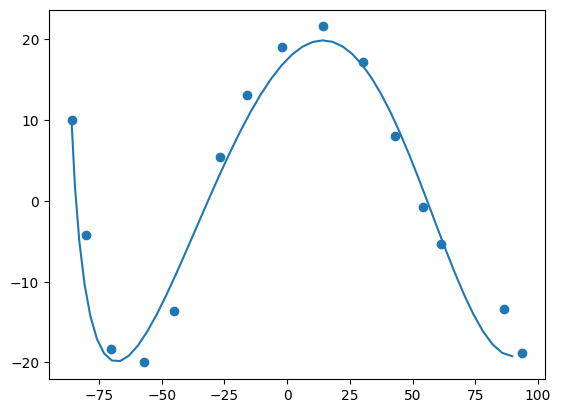

In [160]:
def bernstein_poly(i, n, t):
    """
     The Bernstein polynomial of n, i as a function of t
    """
    return 0 if n <= 0 or i < 0 else ( t**(n-i) ) * (1 - t)**i * comb(n, i)

def bernstein_poly_derivate(i, n, t):
    """
     The Bernstein polynomial derivative of n, i as a function of t
    """
    return n * (bernstein_poly(i-1, n-1, t) - bernstein_poly(i, n-1, t))

def bezier_curve(points, nTimes=50, normal_shift=80):
    """
       Given a set of control points, return the
       bezier curve defined by the control points.

       points should be a list of lists, or list of tuples
       such as [ [1,1], 
                 [2,3], 
                 [4,5], ..[Xn, Yn] ]
        nTimes is the number of time steps, defaults to 1000

        See http://processingjs.nihongoresources.com/bezierinfo/
    """

    nPoints = len(points)
    xPoints = np.array([p[0] for p in points])
    yPoints = np.array([p[1] for p in points])

    t = np.linspace(0.0, 1.0, nTimes)

    polynomial_array = np.array([ bernstein_poly(i, nPoints-1, t) for i in range(0, nPoints)   ])

    xvals = np.dot(xPoints, polynomial_array)
    yvals = np.dot(yPoints, polynomial_array)

    #90 deg rotation matrix
    R = np.array([[0, -1], [1, 0]])

    #compute the normal vector
    normal = np.array([bernstein_poly_derivate(i, nPoints-1, t) for i in range(0, nPoints)   ])

    normals = np.array([-np.dot(yPoints, normal), np.dot(xPoints, normal)]).T
    #normalize normals
    normals = normals / np.linalg.norm(normals, axis=1)[:, np.newaxis]

    xNorm = normals.T[0] * normal_shift
    YNorm = normals.T[1] * normal_shift
    xvals += xNorm
    yvals += YNorm

    return xvals, yvals

bpoints = bezier_curve(controls, normal_shift=0)
plt.plot(bpoints[0], bpoints[1])
plt.scatter(x, y)
plt.show()

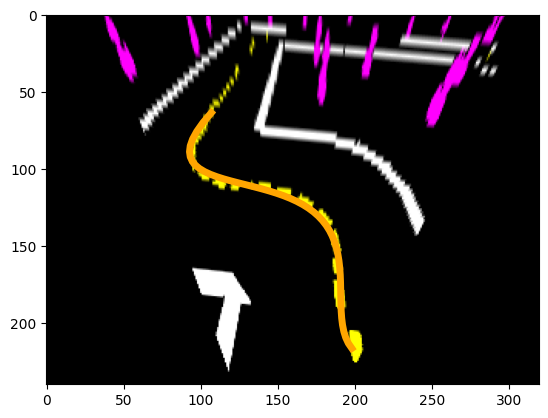

In [164]:
plt.imshow(source, cmap='gray')
#inverse pca for bpoints
bpoints_inversePCA = pca.inverse_transform(np.array(bpoints).T).T

#flip y axis for b points
plt.plot(bpoints_inversePCA[0], source.shape[0] - bpoints_inversePCA[1], color='orange', linewidth=5)


## Spline Interpolation

This methods uses a spline based interpolation between the data points. Yet again the ordering of the points is necessary. Given that this time the procedure is interpolating rather than fitting, it heavely relies on a good clustering. When both the ordering and the clustering are acceptable, the results are flawless

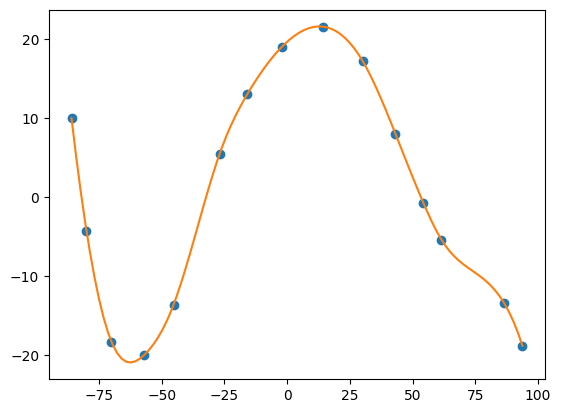

In [157]:
import numpy as np
from scipy.interpolate import splrep, splev

# Fit the data to a spline curve
tck = splrep(x, y)

# Evaluate the spline at a set of points
x_splineFit = np.linspace(min(x), max(x), 100)
y_splineFit = splev(x_splineFit, tck)
splinePoints = np.array([x_splineFit, y_splineFit])

# Plot the original data and the fitted curve
import matplotlib.pyplot as plt
plt.plot(x, y, 'o', label='data')
plt.plot(x_splineFit, y_splineFit)

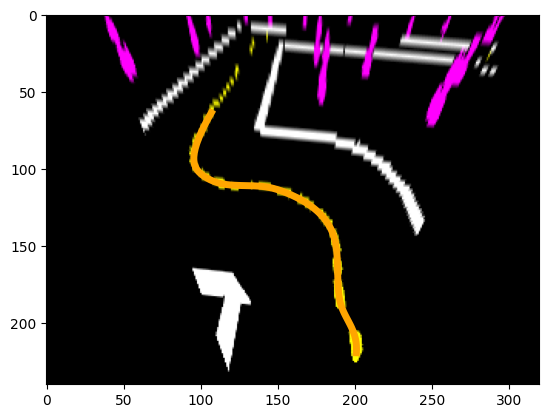

In [158]:
plt.imshow(source, cmap='gray')
#inverse pca for bpoints
splineFit_inversePCA = pca.inverse_transform(np.array(splinePoints).T).T

#flip y axis for b points
plt.plot(splineFit_inversePCA[0], source.shape[0] - splineFit_inversePCA[1], color='orange', linewidth=5)